# PCA feature extraction

In [1]:
from time import time
import scipy.io
from utils import *

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

mat_contents = scipy.io.loadmat('../data/allFaces.mat')
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])

X = faces.T # Data usual format of sample rows and feature columns
y = np.zeros((faces.shape[1], 1)) # Creating labels

j = 0
classes = list(range(len(nfaces)))
for i in nfaces:
  y[j:j+i] = classes.pop(0)
  j = j + i

Split into a training and testing set

In [3]:
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=y)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [4]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_tv.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_tv)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, m, n))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_tv_pca = pca.transform(X_tv)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 1446 faces
done in 12.343s
Projecting the input data on the eigenfaces orthonormal basis
done in 1.643s


### Plotting diagnostic features

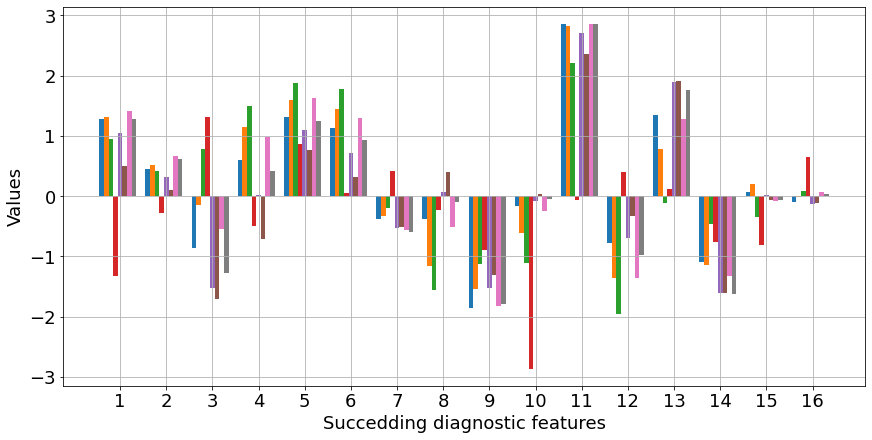

In [5]:
person = 1
subset = faces[:,sum(nfaces[:person]) : sum(nfaces[:(person+1)])]
subset = subset[:, :8] # only take first 8 faces of person 1
data = pca.transform(subset.T)
fileName = "PCAfeatures"

plot_features(data[:, :16])

### Plot Eigenfaces

Just for sanity check whether performing PCA manually via svd seen in [Eigenfaces notebook](./eigenfaces.ipynb) or directly using pca command yields the same eigenfaces

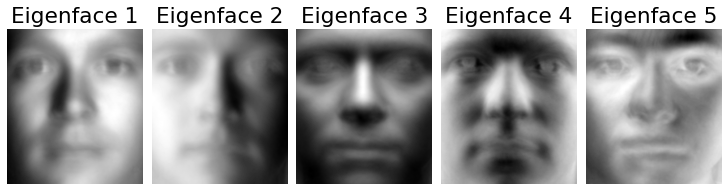

In [6]:
# Plot first 5 eigenfaces
fig1 = plt.figure(figsize=(10, 3))

for i in range(5):
  ax = fig1.add_subplot(1, 5, i+1)
  img = ax.imshow(eigenfaces[i].T)
  img.set_cmap('gray')
  ax.set_title(f"Eigenface {i+1}")
  plt.axis('off')

plt.show()

# Facial Recognition with SVM

### Train a SVM classification model

In [95]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_tv_pca, y_tv.ravel())
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 96.784s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Quantitative evaluation of the model quality on the test set

In [96]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

target_names = [f"Person{n}" for n in range(1,39)]

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

Predicting people's names on the test set
done in 0.372s
              precision    recall  f1-score   support

     Person1       0.96      0.92      0.94        25
     Person2       0.77      0.96      0.86        25
     Person3       0.89      1.00      0.94        25
     Person4       0.96      0.85      0.90        26
     Person5       0.89      0.96      0.92        25
     Person6       0.96      0.96      0.96        26
     Person7       0.96      0.92      0.94        26
     Person8       0.86      1.00      0.93        25
     Person9       1.00      0.92      0.96        25
    Person10       0.85      0.85      0.85        26
    Person11       1.00      0.92      0.96        24
    Person12       0.92      0.96      0.94        24
    Person13       0.85      0.96      0.90        24
    Person14       1.00      0.92      0.96        25
    Person15       0.79      0.88      0.83        25
    Person16       0.96      0.96      0.96        25
    Person17       1.00 

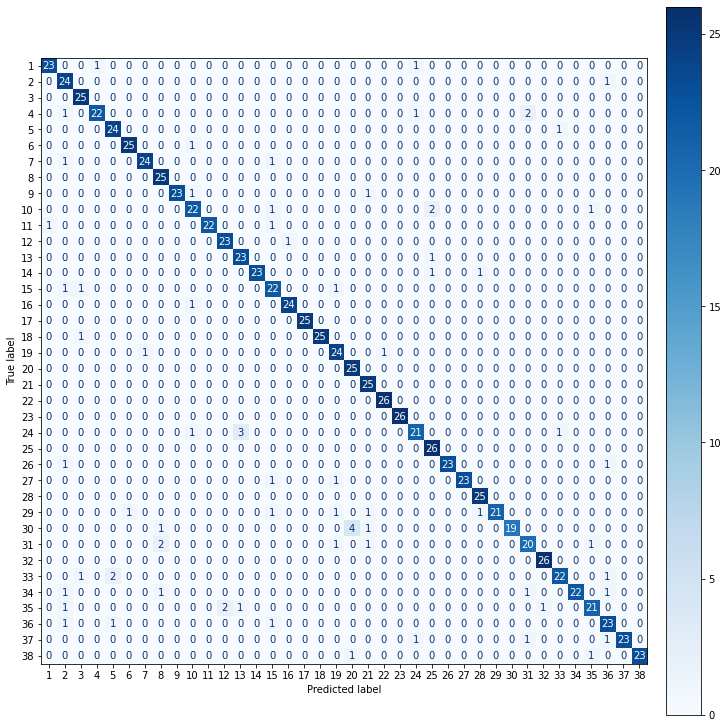

In [109]:
from sklearn.metrics import plot_confusion_matrix
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [10, 10]
plot_confusion_matrix(clf, X_test_pca, y_test, cmap=plt.cm.Blues, display_labels=range(1,39))

### Qualitative evaluation of the predictions using matplotlib

/content/drive/.shortcut-targets-by-id/1lq_20EVZqsY9FvD338D5AwQuZRswD1nS/7-SS20/PyData/Report/utils.py:38: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)


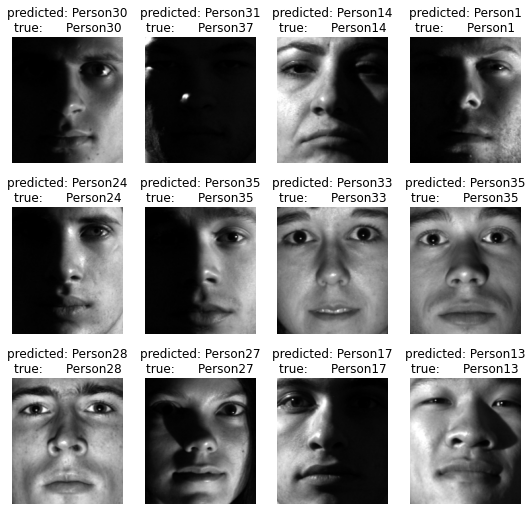

In [110]:
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, m, n)